In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


In [2]:
def identity_block(X, f, filters, stage, block):
    # this block is used when input and output stage has same dimesions
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1),padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='d')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2),name = "avg_pool")(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [56]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tf_utils1 import load_dataset, random_mini_batches, convert_to_one_hot, predict
import matplotlib.pyplot as plt 

(1080, 64, 64, 3)

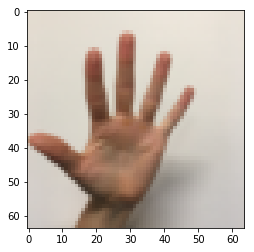

In [48]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
index = 3

plt.imshow(X_train_orig[index])

X_train1 = X_train_orig/255
X_test = X_test_orig/255

Y_train1=Y_train_orig.T
Y_test= Y_test_orig.T
X_train1.shape

In [9]:
#load dataset
X_train2=np.load('sign_dataset\X_trainO.npy')
Y_train2=np.load('sign_dataset\Y_trainO.npy')
X_train2=X_train2/255
Y_TRAIN=np.concatenate((Y_train1,Y_train2,Y_test),axis=0)
X_TRAIN=np.concatenate((X_train1,X_train2,X_test),axis=0)

In [10]:
X_TRAIN.shape

(2437, 64, 64, 3)

In [11]:
from sklearn.model_selection import train_test_split
CX_train,CX_test,CY_train,CY_test=train_test_split(X_TRAIN,Y_TRAIN,test_size=0.2)

In [12]:
CX_train.shape

(1949, 64, 64, 3)

In [13]:
CX_test.shape

(488, 64, 64, 3)

In [14]:
CY_train.shape

(1949, 1)

In [15]:
CY_test.shape

(488, 1)

In [16]:
def _hot_matrix(labels,C):
    C=tf.constant(C)
    _m=tf.one_hot(labels,C,axis=0)
    sess = tf.Session()
    _hot=sess.run(_m)
    sess.close()
    return _hot

In [17]:
CY_train1 =_hot_matrix(CY_train, 6).reshape(6,1949)
CY_test1 =_hot_matrix(CY_test, 6).reshape(6,488)

In [18]:
CY_train1.shape

(6, 1949)

In [19]:
CY_test1.shape

(6, 488)

In [20]:
CY_train_hot=CY_train1.T
CY_test_hot=CY_test1.T

In [21]:
CY_train_hot.shape

(1949, 6)

In [22]:
CY_test_hot.shape

(488, 6)

In [58]:
model.fit(CX_train, CY_train_hot, epochs = 20, batch_size = 32)

Epoch 1/20
1949/1949 [==============================] - 54s 28ms/step - loss: 2.0490 - acc: 0.4997
Epoch 2/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.7035 - acc: 0.7809
Epoch 3/20
1949/1949 [==============================] - 30s 15ms/step - loss: 0.4509 - acc: 0.8645
Epoch 4/20
1949/1949 [==============================] - 30s 15ms/step - loss: 0.1873 - acc: 0.9425
Epoch 5/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.2179 - acc: 0.9389
Epoch 6/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.2641 - acc: 0.9143
Epoch 7/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.1264 - acc: 0.9554
Epoch 8/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.0648 - acc: 0.9820
Epoch 9/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.1897 - acc: 0.9400
Epoch 10/20
1949/1949 [==============================] - 29s 15ms/step - loss: 0.4088 - acc: 0.8876
Epoch 11/

In [59]:
preds = model.evaluate(CX_test, CY_test_hot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

488/488 [==============================] - 4s 9ms/step
Loss = 0.11743078753352165
Test Accuracy = 0.9733606557377049


Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 


c:\users\keshav g\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


[[9.9979740e-01 2.5849406e-06 2.1306652e-05 1.7578376e-04 2.8906870e-06
  1.2975813e-10]]
0


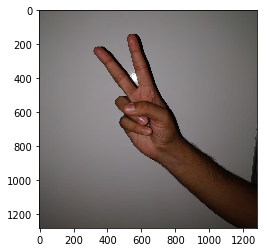

In [63]:
img_path = 'test_images/two.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print((model.predict(x)))
print(np.argmax(model.predict(x)))

In [61]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation